# introduction

This file tests the **load forecasting** for the [Global Energy Forecasting Competition 2012 - Load Forecasting](https://www.kaggle.com/competitions/global-energy-forecasting-competition-2012-load-forecasting/overview).

`Goal`: 

- backcasting and forecasting hourly loads (in kW) for a US utility with 20 zones, plus an additional system level (sum of the 20 zonal level series), totally 21 series.
- to forecast forecast hourly loads from 2008/7/1 to 2008/7/7 where no actual temperatures are given for this week.
- to backcast the 8 weeks of missing data.

`Note`:

- temperature available as one co-variate.
- missing data in `load_history.csv` which required to be backcasted.

`Data`:

- each row represents a day.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel, RNNModel, BlockRNNModel
from darts.utils.likelihood_models import GaussianLikelihood
from darts.utils.callbacks import TFMProgressBar

In [2]:
from energy_forecasting.modules import *
from energy_forecasting.preprocess import remove_tailnan, check_missing
from energy_forecasting.params import Params
from energy_forecasting.modelling import eval_model

In [3]:
params = Params()

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
load = pd.read_csv('../data/raw/GEF2012_load_forecasting/Load_history.csv',  thousands=',')

In [6]:
load = change_timeindex(load)

In [7]:
# which zone=1
load_zone1 = get_series_by_zone(
    df=load, identifier='zone_id', id=1)

In [8]:
# clean data nan at the end

load_zone1 = remove_tailnan(load_zone1)

In [9]:
len(load_zone1)

39414

In [10]:
# load up the covariate
temperature = pd.read_csv('../data/raw/GEF2012_load_forecasting/temperature_history.csv')

In [11]:
temperature = change_timeindex(temperature)

In [12]:
# temperature.head()

In [13]:
# which zone
temp_zone1 = get_series_by_zone(
    df=temperature, identifier='station_id', id=1)

In [14]:
temp_zone1 = remove_tailnan(temp_zone1)

In [15]:
len(temp_zone1)

39414

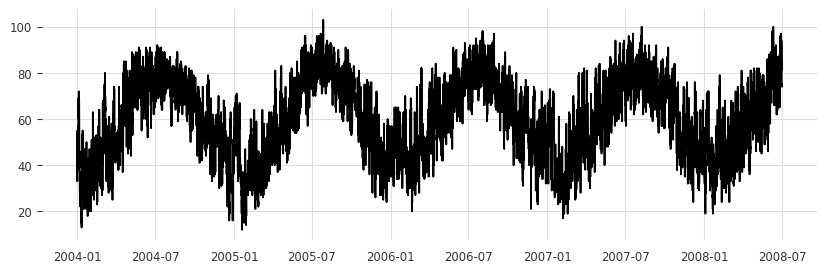

In [16]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(temp_zone1)
# ax.plot(load_zone1)

## the missing data

for now, simply just discard the missing data

In [17]:
# the number of missing data in the covariates
check_missing(temp_zone1)

No of missing values left: 0


In [18]:
# the number of missing data in the target
check_missing(load_zone1)

No of missing values left: 1344


In [19]:
load_filled = fill_missing(load_zone1)

<Axes: xlabel='time'>

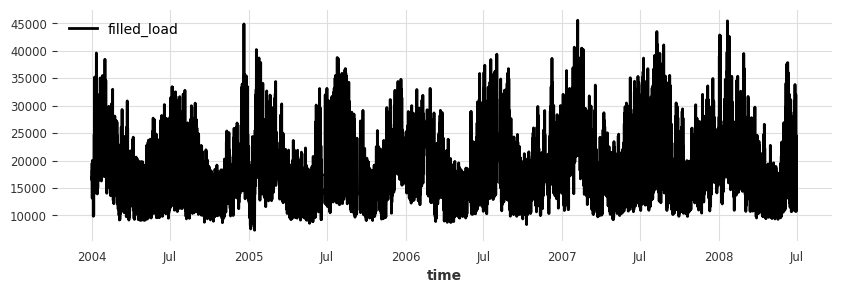

In [20]:
plt.figure(figsize=(10, 3))
load_filled.plot(label='filled_load')

# modelling

temperature_zone_1 --> load_zone_1


In [21]:
# set up the validation range
training_cutoff_load = load_filled.time_index[-(2 * params.forecast_horizon)]

In [22]:
# target

train_load, val_load = load_filled.split_before(training_cutoff_load)

scaler_load = Scaler()
train_load_transformed = scaler_load.fit_transform(train_load)
val_load_transformed = scaler_load.transform(val_load)

load_all_transformed = scaler_load.transform(load_filled)

In [23]:
temp_zone1 = TimeSeries.from_series(temp_zone1)

In [24]:
# produce "past covariates" and transform data

cov_temp_train, cov_temp_val = temp_zone1.split_before(training_cutoff_load)

scaler_temp = Scaler()
scaler_temp.fit(cov_temp_train)

covariates_temp_transformed = scaler_temp.transform(temp_zone1)
# change the dtype in case error
covariates_temp_transformed = covariates_temp_transformed.astype('float32')

## `TFT` model

In [25]:
# use `add_encoders` as we don't have future covariates
TFT_model = TFTModel(
    input_chunk_length=params.input_chunk_length,
    output_chunk_length=params.forecast_horizon,
    hidden_size=16,
    lstm_layers=1,
    batch_size=32,
    n_epochs=1,
    dropout=0.1,
    add_encoders={
        "cyclic": {"future": ["month"]},
    "datetime_attribute": {"future": ["hour", "dayofweek"]},},
    add_relative_index=False,
    optimizer_kwargs={"lr": 1e-3},
    random_state=42,
)

In [26]:
# fit the model with past covariates
TFT_model.fit(
    train_load_transformed, 
    past_covariates=covariates_temp_transformed, 
    verbose=True
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 3.7 K 
5  | decoder_vsn                       | _VariableSelectionNetwork        | 2.4 K 
6  | static_context_grn                | _GatedResidualNetwork            | 1.1 K 
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 1.1 K 
8  | static_cont

Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.


TFTModel(hidden_size=16, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=144, output_chunk_length=48, batch_size=32, n_epochs=1, add_encoders={'cyclic': {'future': ['month']}, 'datetime_attribute': {'future': ['hour', 'dayofweek']}}, optimizer_kwargs={'lr': 0.001}, random_state=42)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

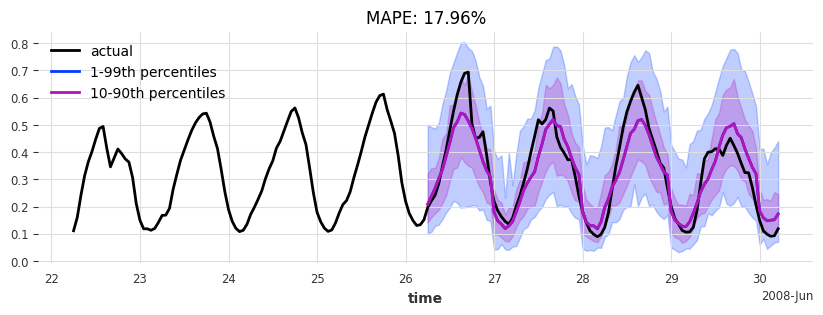

In [29]:
# validation
mape_TFT = eval_model(
                model = TFT_model, 
                n = 96, 
                actual_series = load_all_transformed[
                            train_load.end_time() - (2 * 48 - 1) * train_load.freq :], 
                val_series = val_load_transformed,
                metric='mape')

## `LSTM AutoEncoder` model

In [30]:
def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

In [31]:
model_en = BlockRNNModel(
    model="LSTM",
    hidden_dim=20,
    n_rnn_layers=2,
    dropout=0.2,
    batch_size=16,
    n_epochs=1,
    optimizer_kwargs={"lr": 1e-3},
    random_state=0,
    input_chunk_length=params.input_chunk_length,
    output_chunk_length=params.forecast_horizon,
    likelihood=GaussianLikelihood(),
    model_name="LSTM_Autoencoder",
    save_checkpoints=True,  # store the latest and best performing epochs
    force_reset=True,
    **generate_torch_kwargs(),
)

In [32]:
model_en.fit(
    series=train_load_transformed, 
    past_covariates=covariates_temp_transformed, 
    verbose=True
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 5.3 K 
4 | fc            | Sequential       | 2.0 K 
---------------------------------------------------
7.3 K     Trainable params
0         Non-trainable params
7.3 K     Total params
0.029     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/gpflow/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:369: `ModelCheckpoint(monitor='val_loss')` could not find the monitored key in the returned metrics: ['train_loss', 'epoch', 'step']. HINT: Did you call `log('val_loss', value)` in the `LightningModule`?
`Trainer.fit` stopped: `max_epochs=1` reached.


BlockRNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=2, hidden_fc_sizes=None, dropout=0.2, batch_size=16, n_epochs=1, optimizer_kwargs={'lr': 0.001}, random_state=0, input_chunk_length=144, output_chunk_length=48, likelihood=GaussianLikelihood(prior_mu=None, prior_sigma=None, prior_strength=1.0, beta_nll=0.0), model_name=LSTM_Autoencoder, save_checkpoints=True, force_reset=True, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x7fcb773b6170>]})

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


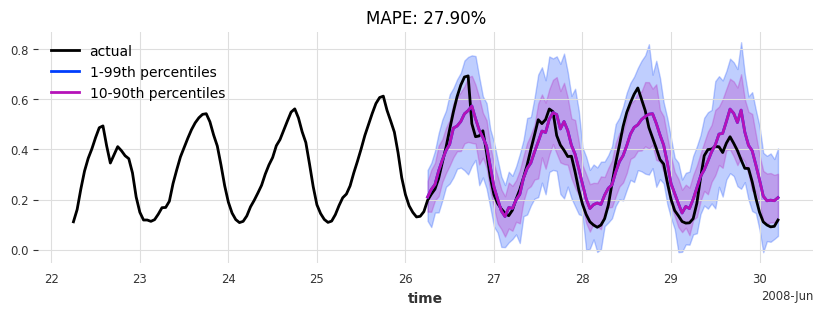

In [33]:
mape_LSTM_ACDER = eval_model(
                model = model_en, 
                n = 96, 
                actual_series = load_all_transformed[
                            train_load.end_time() - (2 * 48 - 1) * train_load.freq :], 
                val_series = val_load_transformed,
                metric='mape')

### performance comparison

In [ ]:
# metrics = {}
# metrics